In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [6]:
# read the pickle file
with open('../tracker_stubs/ball_detections.pkl', 'rb') as f:
    ball_positions = pickle.load(f)

In [7]:
ball_positions = [x.get(1,[]) for x in ball_positions]
# convert the list into pandas dataframe
df_ball_positions = pd.DataFrame(ball_positions,columns=['x1','y1','x2','y2'])

# interpolate the missing values
df_ball_positions = df_ball_positions.interpolate()
df_ball_positions = df_ball_positions.bfill()

/var/folders/96/_n1lf8k53dxg2d2mxxmwwjl80000gn/T/ipykernel_97564/1998881449.py:45: UserWarning: Glyph 29699 (\N{CJK UNIFIED IDEOGRAPH-7403}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/96/_n1lf8k53dxg2d2mxxmwwjl80000gn/T/ipykernel_97564/1998881449.py:45: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/96/_n1lf8k53dxg2d2mxxmwwjl80000gn/T/ipykernel_97564/1998881449.py:45: UserWarning: Glyph 22402 (\N{CJK UNIFIED IDEOGRAPH-5782}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/96/_n1lf8k53dxg2d2mxxmwwjl80000gn/T/ipykernel_97564/1998881449.py:45: UserWarning: Glyph 30452 (\N{CJK UNIFIED IDEOGRAPH-76F4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/96/_n1lf8k53dxg2d2mxxmwwjl80000gn/T/ipykernel_97564/1998881449.py:45: UserWarning: Glyph 20301 (\N{CJK UNIFIED IDEOGRAPH-4F4D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/96/_n1l

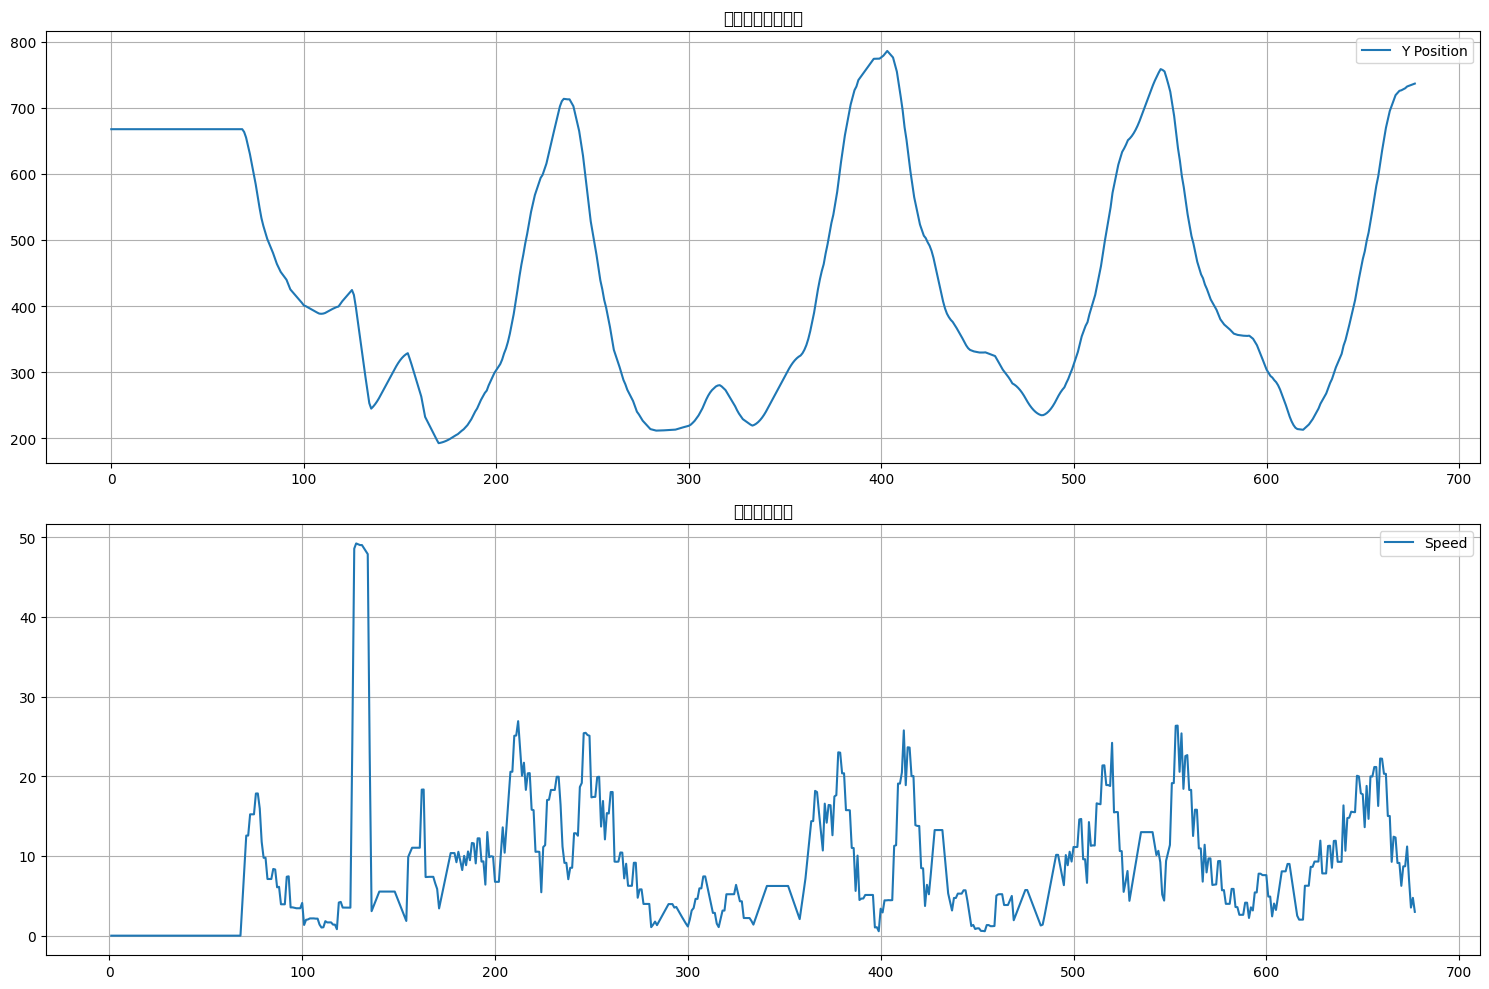

In [9]:
# 计算球的中心坐标
df_ball_positions['mid_x'] = (df_ball_positions['x1'] + df_ball_positions['x2'])/2
df_ball_positions['mid_y'] = (df_ball_positions['y1'] + df_ball_positions['y2'])/2

# 使用更大的窗口进行平滑处理，减少噪声影响
window_size = 9
df_ball_positions['mid_x_smooth'] = df_ball_positions['mid_x'].rolling(
    window=window_size, 
    min_periods=1, 
    center=True
).mean()
df_ball_positions['mid_y_smooth'] = df_ball_positions['mid_y'].rolling(
    window=window_size, 
    min_periods=1, 
    center=True
).mean()

# 计算速度（一阶导数）
df_ball_positions['vx'] = df_ball_positions['mid_x_smooth'].diff()
df_ball_positions['vy'] = df_ball_positions['mid_y_smooth'].diff()
df_ball_positions['speed'] = np.sqrt(df_ball_positions['vx']**2 + df_ball_positions['vy']**2)

# 计算加速度（二阶导数）
df_ball_positions['ax'] = df_ball_positions['vx'].diff()
df_ball_positions['ay'] = df_ball_positions['vy'].diff()
df_ball_positions['acceleration'] = np.sqrt(df_ball_positions['ax']**2 + df_ball_positions['ay']**2)

# 可视化球的轨迹和速度
plt.figure(figsize=(15, 10))

# 第一个子图：显示y轴位置
plt.subplot(2, 1, 1)
plt.plot(df_ball_positions['mid_y_smooth'], label='Y Position')
plt.title('球的垂直位置变化')
plt.legend()
plt.grid(True)

# 第二个子图：显示速度
plt.subplot(2, 1, 2)
plt.plot(df_ball_positions['speed'], label='Speed')
plt.title('球的速度变化')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()




发现击球点 帧号: 126
速度变化: 37.14
加速度: 24.50
与上一击球点间隔: 0

发现击球点 帧号: 227
速度变化: 8.15
加速度: 5.66
与上一击球点间隔: 0

发现击球点 帧号: 407
速度变化: 9.44
加速度: 7.43
与上一击球点间隔: 0

发现击球点 帧号: 551
速度变化: 11.15
加速度: 7.83
与上一击球点间隔: 0


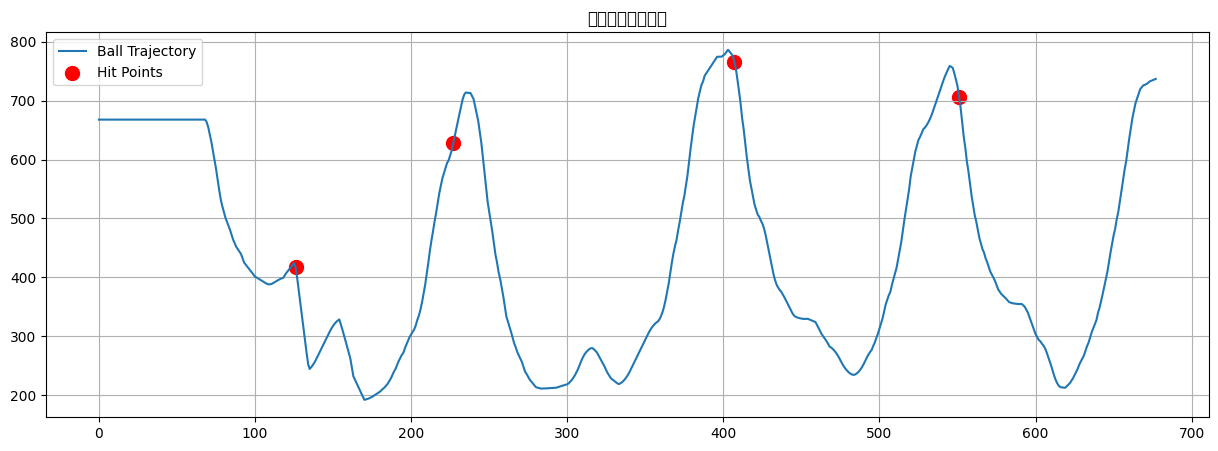


最终检测到的击球点帧号: [126, 227, 407, 551]
总计检测到 4 个击球点


In [10]:

# 设置判定阈值
min_frames_between_hits = 45  # 两次击球之间的最小帧数
min_speed_change = 8.0  # 速度变化阈值
min_acceleration = 5.0  # 加速度阈值

potential_hits = []
last_hit_frame = -min_frames_between_hits

# 遍历所有帧，寻找可能的击球点
for i in range(window_size, len(df_ball_positions) - window_size):
    # 获取当前帧的各项指标
    speed = df_ball_positions['speed'].iloc[i]
    acceleration = df_ball_positions['acceleration'].iloc[i]
    
    # 判断是否满足击球条件
    if (acceleration > min_acceleration and  # 加速度显著
        i - last_hit_frame >= min_frames_between_hits):  # 与上一个击球点间隔足够
        
        # 检查前后帧的速度变化
        speed_before = df_ball_positions['speed'].iloc[i-3:i].mean()
        speed_after = df_ball_positions['speed'].iloc[i:i+3].mean()
        speed_change = abs(speed_after - speed_before)
        
        # 确认是否为真实的击球点
        if speed_change > min_speed_change:
            potential_hits.append(i)
            last_hit_frame = i
            
            print(f"\n发现击球点 帧号: {i}")
            print(f"速度变化: {speed_change:.2f}")
            print(f"加速度: {acceleration:.2f}")
            print(f"与上一击球点间隔: {i - last_hit_frame}")

# 在图上标记击球点
plt.figure(figsize=(15, 5))
plt.plot(df_ball_positions['mid_y_smooth'], label='Ball Trajectory')
plt.scatter(potential_hits, df_ball_positions['mid_y_smooth'].iloc[potential_hits], 
           color='red', marker='o', s=100, label='Hit Points')
plt.title('球的轨迹和击球点')
plt.legend()
plt.grid(True)
plt.show()

print(f"\n最终检测到的击球点帧号: {potential_hits}")
print(f"总计检测到 {len(potential_hits)} 个击球点")

In [6]:
df_ball_positions['delta_y'] = df_ball_positions['mid_y_rolling_mean'].diff()


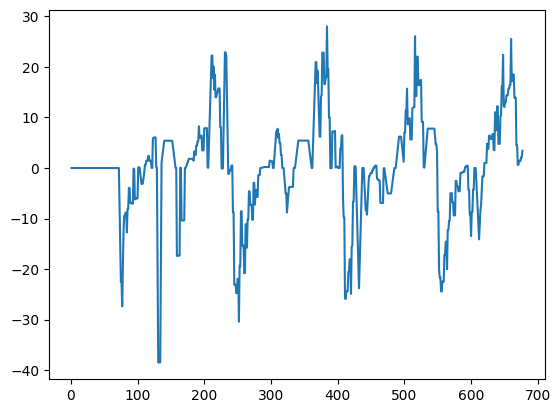

In [7]:

# plot mid_y_rolling_mean
plt.plot(df_ball_positions['delta_y'])

In [9]:
df_ball_positions['ball_hit']=0


In [10]:
minimum_change_frames_for_hit = 25
for i in range(1,len(df_ball_positions)- int(minimum_change_frames_for_hit*1.2) ):
    negative_position_change = df_ball_positions['delta_y'].iloc[i] >0 and df_ball_positions['delta_y'].iloc[i+1] <0
    positive_position_change = df_ball_positions['delta_y'].iloc[i] <0 and df_ball_positions['delta_y'].iloc[i+1] >0

    if negative_position_change or positive_position_change:
        change_count = 0 
        for change_frame in range(i+1, i+int(minimum_change_frames_for_hit*1.2)+1):
            negative_position_change_following_frame = df_ball_positions['delta_y'].iloc[i] >0 and df_ball_positions['delta_y'].iloc[change_frame] <0
            positive_position_change_following_frame = df_ball_positions['delta_y'].iloc[i] <0 and df_ball_positions['delta_y'].iloc[change_frame] >0

            if negative_position_change and negative_position_change_following_frame:
                change_count+=1
            elif positive_position_change and positive_position_change_following_frame:
                change_count+=1
    
        if change_count>minimum_change_frames_for_hit-1:
            df_ball_positions['ball_hit'].iloc[i] = 1

frame_nums_with_ball_hits = df_ball_positions[df_ball_positions['ball_hit']==1].index.tolist()

/var/folders/96/_n1lf8k53dxg2d2mxxmwwjl80000gn/T/ipykernel_31955/3752280353.py:18: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_ball_positions['ball_hit'].iloc[i] = 1
/var/folders/96/_n1lf8k53dxg2d2mxxmwwjl80000gn/T/ipykernel_31955/37522

In [11]:
df_ball_positions[df_ball_positions['ball_hit']==1]


,x1,y1,x2,y2,mid_y,mid_y_rolling_mean,delta_y,ball_hit
135,653.848816,230.841171,669.222534,246.809845,238.825508,238.825508,-19.234861,1
172,585.065979,184.464523,599.957947,199.356491,191.910507,191.910507,-0.017912,1
235,1210.067261,703.311646,1231.326172,724.826904,714.069275,715.349487,6.988460,1
242,1273.509155,702.790466,1295.341187,725.093628,713.942047,712.908331,0.506598,1
283,1130.436760,203.338173,1146.751961,219.653374,211.495773,211.492784,-1.405209,1
333,1034.146736,211.868828,1047.462029,225.184120,218.526474,218.519844,-3.728577,1
362,969.057587,316.786652,989.452972,337.182037,326.984344,326.984344,-0.000323,1
407,840.231873,795.916687,860.200623,817.880005,806.898346,795.254993,6.460284,1
439,811.608002,371.658417,829.532928,389.583344,380.620880,380.620880,0.000037,1
458,795.437866,324.277954,807.826965,338.294769,331.286362,330.652377,0.479977,1
